# Chapter 2: Mathematical Foundations of Fractals

This notebook develops the mathematical framework for understanding and measuring fractals, with practical implementations of key algorithms.

**Topics covered:**
- Topological vs Fractal Dimension
- Box-Counting (Minkowski-Bouligand) Dimension
- Differential Box-Counting for Grayscale Images
- Power Laws and Scaling Relations
- Hurst Exponent and Fractional Brownian Motion
- Lacunarity: Measuring Texture and Gaps

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, stats
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Set default figure style
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 100

## 2.1 Topological vs Fractal Dimension

### Integer Dimensions in Topology
- A **point** has dimension 0
- A **line** has dimension 1
- A **plane** has dimension 2
- A **volume** has dimension 3

### Why Fractals Have Non-Integer Dimensions

The key insight is **dimension as a scaling exponent**. For regular geometric objects:
- A line segment scaled by factor $r$ produces $r^1$ copies
- A square scaled by factor $r$ produces $r^2$ copies
- A cube scaled by factor $r$ produces $r^3$ copies

In general: $N = r^D$, so:

$$D = \frac{\log N}{\log r}$$

For the Koch curve: scaling by $r = 3$ produces $N = 4$ copies, yielding $D = \frac{\log 4}{\log 3} \approx 1.262$

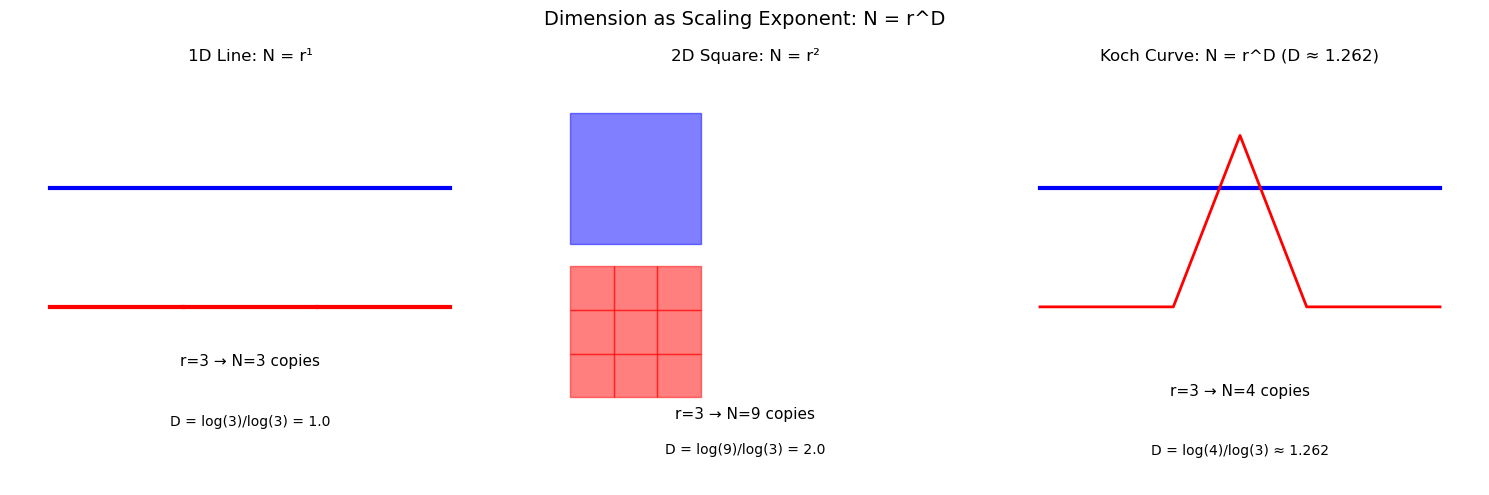

In [2]:
# Demonstrate scaling dimension for regular objects
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1D: Line segment
ax = axes[0]
ax.plot([0, 1], [0.5, 0.5], 'b-', lw=3, label='Original (length 1)')
for i in range(3):
    ax.plot([i/3, (i+1)/3], [0.3, 0.3], 'r-', lw=3)
ax.annotate('r=3 → N=3 copies', xy=(0.5, 0.2), ha='center', fontsize=11)
ax.annotate(f'D = log(3)/log(3) = 1.0', xy=(0.5, 0.1), ha='center', fontsize=10)
ax.set_title('1D Line: N = r¹', fontsize=12)
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(0, 0.7)
ax.axis('off')

# 2D: Square
ax = axes[1]
square = plt.Rectangle((0.1, 0.4), 0.3, 0.3, fill=True, alpha=0.5, color='blue')
ax.add_patch(square)
for i in range(3):
    for j in range(3):
        sq = plt.Rectangle((0.1 + i*0.1, 0.05 + j*0.1), 0.1, 0.1, fill=True, alpha=0.5, color='red')
        ax.add_patch(sq)
ax.annotate('r=3 → N=9 copies', xy=(0.5, 0.0), ha='center', fontsize=11)
ax.annotate(f'D = log(9)/log(3) = 2.0', xy=(0.5, -0.08), ha='center', fontsize=10)
ax.set_title('2D Square: N = r²', fontsize=12)
ax.set_xlim(0, 1)
ax.set_ylim(-0.15, 0.8)
ax.set_aspect('equal')
ax.axis('off')

# Koch curve
ax = axes[2]
# Draw original and scaled
ax.plot([0, 1], [0.5, 0.5], 'b-', lw=3, label='Original')
# One iteration of Koch
koch_x = [0, 1/3, 0.5, 2/3, 1]
koch_y = [0.3, 0.3, 0.3 + np.sqrt(3)/6, 0.3, 0.3]
ax.plot(koch_x, koch_y, 'r-', lw=2)
ax.annotate('r=3 → N=4 copies', xy=(0.5, 0.15), ha='center', fontsize=11)
ax.annotate(f'D = log(4)/log(3) ≈ 1.262', xy=(0.5, 0.05), ha='center', fontsize=10)
ax.set_title('Koch Curve: N = r^D (D ≈ 1.262)', fontsize=12)
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(0, 0.7)
ax.axis('off')

fig.suptitle('Dimension as Scaling Exponent: N = r^D', fontsize=14)
plt.tight_layout()
plt.show()

## 2.2 Box-Counting (Minkowski-Bouligand) Dimension

The box-counting dimension provides a practical method for estimating fractal dimension from data.

### Definition

Cover the set $S$ with a grid of boxes of side length $\varepsilon$. Let $N(\varepsilon)$ denote the number of boxes that intersect $S$:

$$D_B = \lim_{\varepsilon \to 0} \frac{\log N(\varepsilon)}{\log(1/\varepsilon)}$$

### Computational Procedure

1. Overlay a grid of boxes with side length $\varepsilon$
2. Count $N(\varepsilon)$ boxes containing part of the set
3. Repeat for multiple scales (powers of 2)
4. Plot $\log N(\varepsilon)$ vs $\log(1/\varepsilon)$
5. The **slope** estimates $D_B$

In [3]:
def box_count(image, box_sizes=None):
    """
    Compute box-counting dimension of a binary image.
    
    Parameters:
    - image: 2D binary numpy array (True/1 = fractal, False/0 = background)
    - box_sizes: list of box sizes to use (default: powers of 2)
    
    Returns:
    - sizes: array of box sizes
    - counts: array of box counts
    - dimension: estimated fractal dimension
    - r_squared: R² of the linear fit
    """
    # Ensure binary image
    Z = (image > 0).astype(int)
    
    # Default box sizes: powers of 2 up to image size
    if box_sizes is None:
        max_power = int(np.log2(min(Z.shape)))
        box_sizes = 2 ** np.arange(1, max_power)
    
    counts = []
    sizes = []
    
    for size in box_sizes:
        # Count non-empty boxes
        # Reshape into boxes and check if any pixel is set
        h, w = Z.shape
        h_trim = (h // size) * size
        w_trim = (w // size) * size
        Z_trim = Z[:h_trim, :w_trim]
        
        # Reshape to count boxes
        boxes = Z_trim.reshape(h_trim // size, size, w_trim // size, size)
        box_sums = boxes.any(axis=(1, 3))  # True if any pixel in box is set
        count = np.sum(box_sums)
        
        counts.append(count)
        sizes.append(size)
    
    sizes = np.array(sizes)
    counts = np.array(counts)
    
    # Linear regression on log-log scale
    log_sizes = np.log(1.0 / sizes)
    log_counts = np.log(counts)
    
    # Filter out any invalid values
    valid = np.isfinite(log_counts) & (counts > 0)
    
    if np.sum(valid) >= 2:
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            log_sizes[valid], log_counts[valid]
        )
        dimension = slope
        r_squared = r_value ** 2
    else:
        dimension = np.nan
        r_squared = np.nan
    
    return sizes, counts, dimension, r_squared

Sierpinski Carpet Box-Counting Results:
  Measured D = 2.0155
  Theoretical D = log(8)/log(3) = 1.8928
  Error = 0.1228
  R² = 0.9973


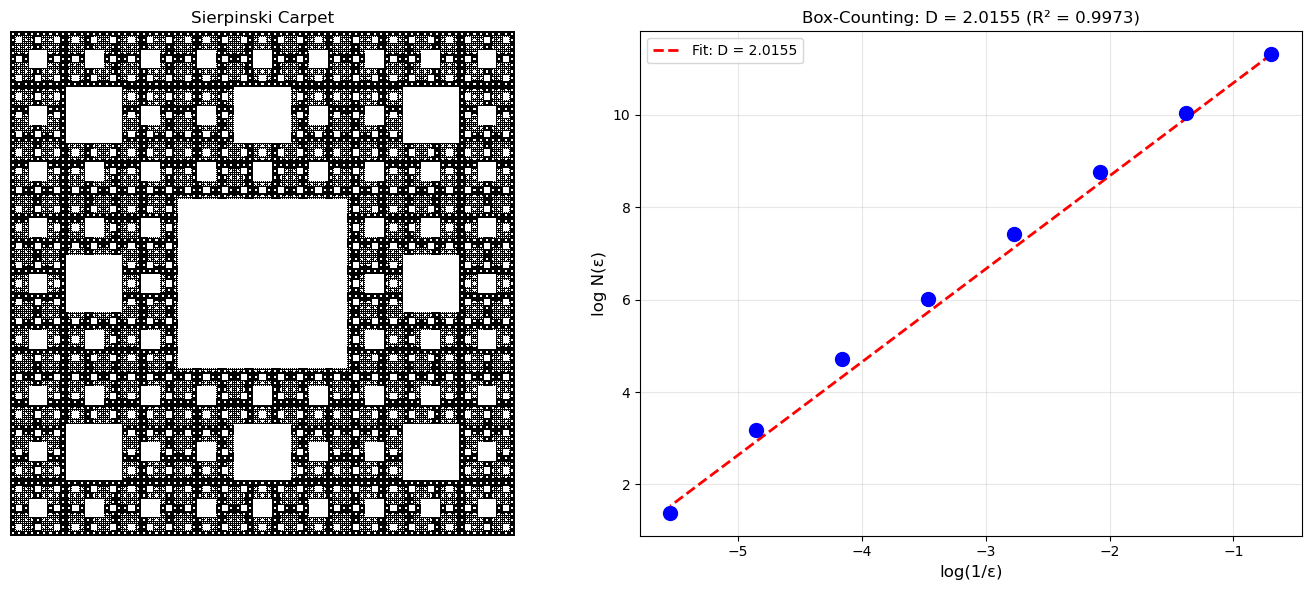

In [4]:
def generate_sierpinski(size, depth):
    """Generate Sierpinski carpet as binary image."""
    carpet = np.ones((size, size), dtype=bool)
    
    for d in range(1, depth + 1):
        step = size // (3 ** d)
        for y in range(0, size, step * 3):
            for x in range(0, size, step * 3):
                carpet[y + step:y + 2*step, x + step:x + 2*step] = False
    
    return carpet

# Generate Sierpinski carpet and compute box-counting dimension
carpet = generate_sierpinski(729, 6)  # 729 = 3^6

sizes, counts, dim, r2 = box_count(carpet)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Show fractal
axes[0].imshow(carpet, cmap='binary', interpolation='nearest')
axes[0].set_title('Sierpinski Carpet', fontsize=12)
axes[0].axis('off')

# Log-log plot
log_sizes = np.log(1.0 / sizes)
log_counts = np.log(counts)

axes[1].scatter(log_sizes, log_counts, s=100, c='blue', zorder=5)
axes[1].plot(log_sizes, dim * log_sizes + (log_counts[0] - dim * log_sizes[0]), 
             'r--', lw=2, label=f'Fit: D = {dim:.4f}')
axes[1].set_xlabel('log(1/ε)', fontsize=12)
axes[1].set_ylabel('log N(ε)', fontsize=12)
axes[1].set_title(f'Box-Counting: D = {dim:.4f} (R² = {r2:.4f})', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Theoretical value
D_theory = np.log(8) / np.log(3)
print(f"Sierpinski Carpet Box-Counting Results:")
print(f"  Measured D = {dim:.4f}")
print(f"  Theoretical D = log(8)/log(3) = {D_theory:.4f}")
print(f"  Error = {abs(dim - D_theory):.4f}")
print(f"  R² = {r2:.4f}")

plt.tight_layout()
plt.show()

Koch Curve Box-Counting Results:
  Filled region D = 1.9072 (expected ~2.0)
  Boundary D = 1.2980
  Theoretical D = log(4)/log(3) = 1.2619


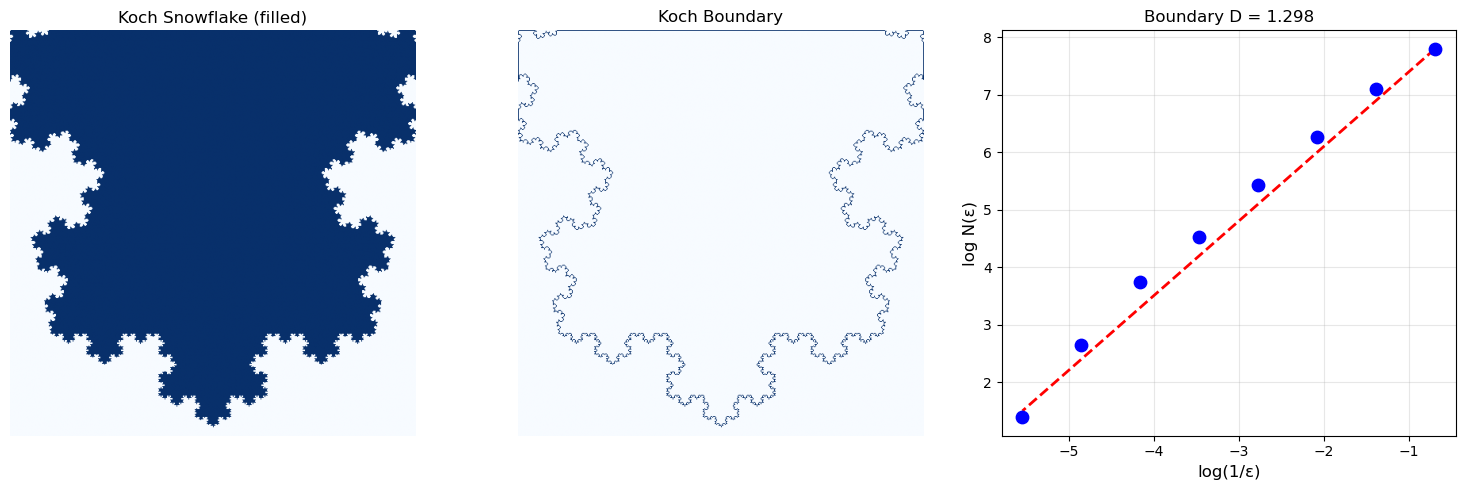

In [5]:
def generate_koch_image(size, depth):
    """Generate Koch snowflake as a binary image."""
    from PIL import Image, ImageDraw
    
    def koch_points(p1, p2, depth):
        if depth == 0:
            return [p1, p2]
        dx, dy = p2[0] - p1[0], p2[1] - p1[1]
        a = p1
        b = (p1[0] + dx/3, p1[1] + dy/3)
        d = (p1[0] + 2*dx/3, p1[1] + 2*dy/3)
        e = p2
        cx = b[0] + dx/6 - dy * np.sqrt(3)/6
        cy = b[1] + dy/6 + dx * np.sqrt(3)/6
        c = (cx, cy)
        points = []
        for seg in [(a, b), (b, c), (c, d), (d, e)]:
            pts = koch_points(seg[0], seg[1], depth - 1)
            points.extend(pts[:-1])
        points.append(e)
        return points
    
    # Create image
    img = Image.new('1', (size, size), 0)
    draw = ImageDraw.Draw(img)
    
    # Triangle vertices
    margin = size * 0.1
    h = (size - 2*margin) * np.sqrt(3) / 2
    vertices = [
        (margin, size - margin - (size - h)/2),
        (size - margin, size - margin - (size - h)/2),
        (size/2, margin + (size - h)/2 - h)
    ]
    
    # Get all points
    all_points = []
    for i in range(3):
        pts = koch_points(vertices[i], vertices[(i+1)%3], depth)
        all_points.extend(pts[:-1])
    all_points.append(all_points[0])
    
    # Draw filled polygon
    draw.polygon(all_points, fill=1, outline=1)
    
    return np.array(img)

# Generate Koch snowflake
koch = generate_koch_image(512, 5)

# Box counting
sizes, counts, dim, r2 = box_count(koch)

# For boundary dimension, we need the perimeter
from scipy import ndimage
# Extract boundary using morphological gradient
struct = ndimage.generate_binary_structure(2, 1)
eroded = ndimage.binary_erosion(koch, struct)
boundary = koch & ~eroded

sizes_b, counts_b, dim_b, r2_b = box_count(boundary)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(koch, cmap='Blues')
axes[0].set_title('Koch Snowflake (filled)', fontsize=12)
axes[0].axis('off')

axes[1].imshow(boundary, cmap='Blues')
axes[1].set_title('Koch Boundary', fontsize=12)
axes[1].axis('off')

# Log-log plot for boundary
log_sizes = np.log(1.0 / sizes_b)
log_counts = np.log(counts_b)
axes[2].scatter(log_sizes, log_counts, s=80, c='blue', zorder=5)
axes[2].plot(log_sizes, dim_b * log_sizes + (log_counts[0] - dim_b * log_sizes[0]), 
             'r--', lw=2)
axes[2].set_xlabel('log(1/ε)', fontsize=12)
axes[2].set_ylabel('log N(ε)', fontsize=12)
axes[2].set_title(f'Boundary D = {dim_b:.3f}', fontsize=12)
axes[2].grid(True, alpha=0.3)

D_koch_theory = np.log(4) / np.log(3)
print(f"Koch Curve Box-Counting Results:")
print(f"  Filled region D = {dim:.4f} (expected ~2.0)")
print(f"  Boundary D = {dim_b:.4f}")
print(f"  Theoretical D = log(4)/log(3) = {D_koch_theory:.4f}")

plt.tight_layout()
plt.show()

## 2.3 Differential Box-Counting for Grayscale Images

Standard box-counting applies to binary data. The **Differential Box-Counting** (DBC) method extends this to grayscale images.

### Method

For an $M \times M$ grayscale image with intensity in $[0, G-1]$:

1. Partition into $s \times s$ pixel blocks
2. Map intensity to a third dimension (height)
3. For each block, count 3D boxes needed: $n_r(i,j) = \lceil \frac{\max(I) - \min(I) + 1}{s'} \rceil$
4. Sum: $N_r = \sum_{i,j} n_r(i,j)$
5. Regress: $D_B$ from slope of $\log N_r$ vs $\log(1/r)$

In [6]:
def differential_box_counting(image, box_sizes=None):
    """
    Compute fractal dimension of grayscale image using DBC method.
    
    Parameters:
    - image: 2D grayscale numpy array
    - box_sizes: list of box sizes (default: powers of 2)
    
    Returns:
    - sizes, counts, dimension, r_squared
    """
    # Normalize to 0-255 range
    Z = ((image - image.min()) / (image.max() - image.min()) * 255).astype(int)
    G = 256
    M = min(Z.shape)
    
    if box_sizes is None:
        max_power = int(np.log2(M)) - 1
        box_sizes = 2 ** np.arange(2, max_power)
    
    counts = []
    sizes = []
    
    for s in box_sizes:
        # Height of 3D box
        s_prime = max(1, int(s * G / M))
        
        h, w = Z.shape
        h_trim = (h // s) * s
        w_trim = (w // s) * s
        Z_trim = Z[:h_trim, :w_trim]
        
        total_boxes = 0
        for i in range(0, h_trim, s):
            for j in range(0, w_trim, s):
                block = Z_trim[i:i+s, j:j+s]
                i_max = block.max()
                i_min = block.min()
                # Number of boxes needed to cover this column
                n_boxes = max(1, int(np.ceil((i_max - i_min + 1) / s_prime)))
                total_boxes += n_boxes
        
        counts.append(total_boxes)
        sizes.append(s)
    
    sizes = np.array(sizes)
    counts = np.array(counts)
    
    # Linear regression
    log_sizes = np.log(1.0 / sizes)
    log_counts = np.log(counts)
    
    valid = np.isfinite(log_counts) & (counts > 0)
    if np.sum(valid) >= 2:
        slope, intercept, r_value, _, _ = stats.linregress(
            log_sizes[valid], log_counts[valid]
        )
        dimension = slope
        r_squared = r_value ** 2
    else:
        dimension = np.nan
        r_squared = np.nan
    
    return sizes, counts, dimension, r_squared

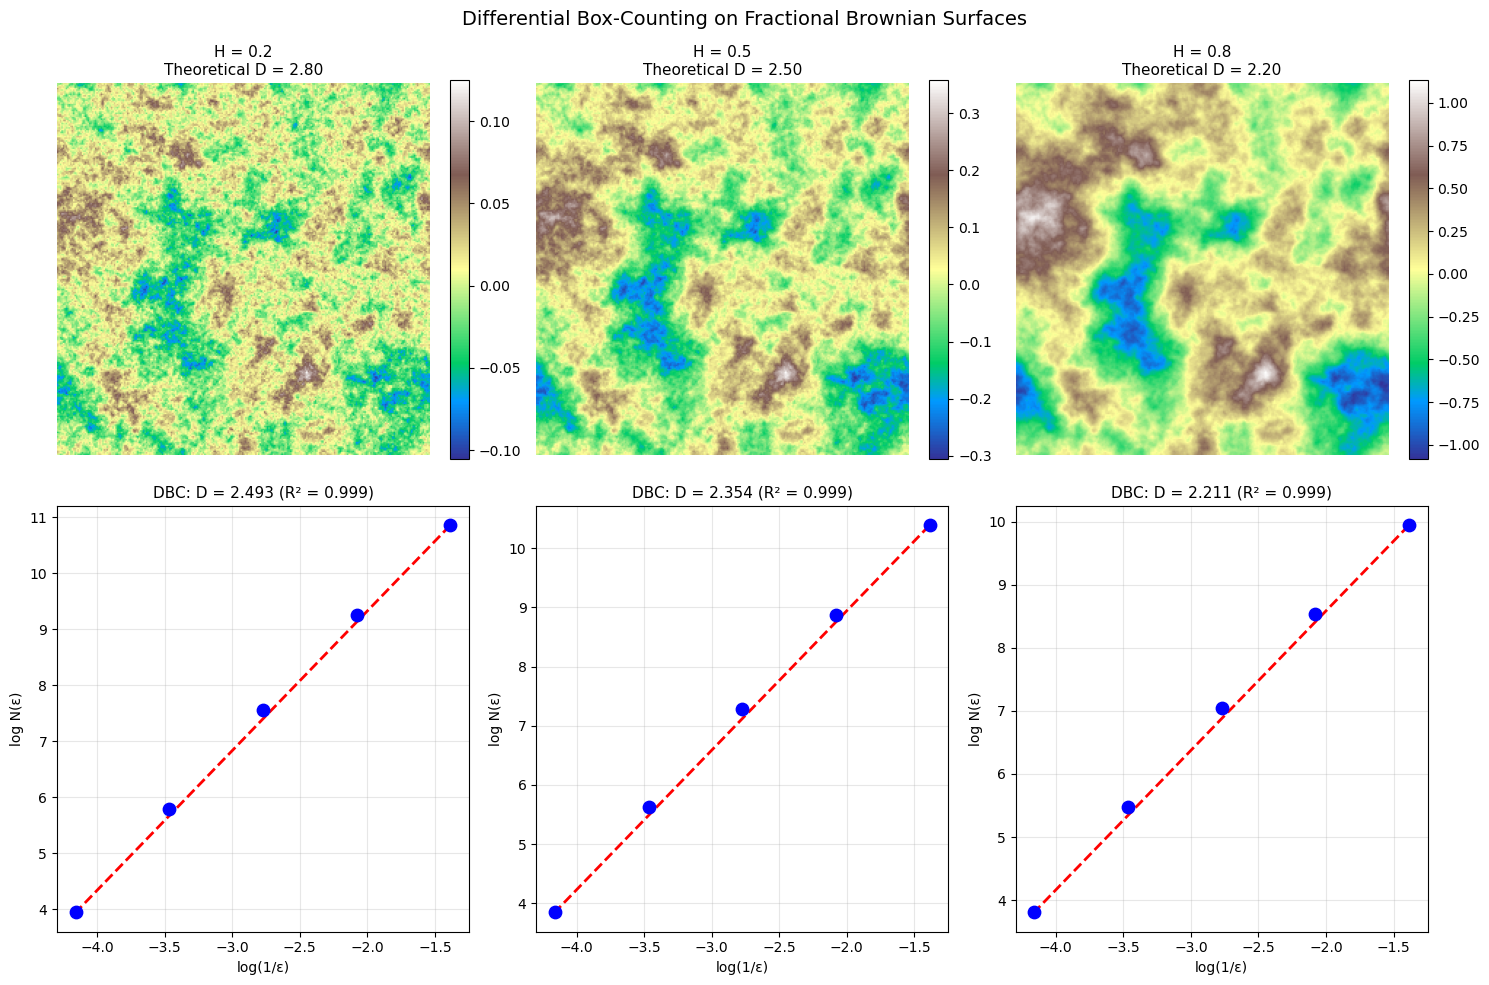


Fractional Brownian Surface: D = 3 - H
Higher H → smoother surface → lower dimension


In [7]:
def generate_fbm_surface(size, H=0.5):
    """Generate fractional Brownian surface using spectral synthesis."""
    # Generate random phase
    np.random.seed(42)
    
    # Frequency grid
    freq_x = np.fft.fftfreq(size)
    freq_y = np.fft.fftfreq(size)
    fx, fy = np.meshgrid(freq_x, freq_y)
    
    # Power spectrum: S(f) ~ 1/f^(2H+2) for 2D
    f_magnitude = np.sqrt(fx**2 + fy**2)
    f_magnitude[0, 0] = 1  # Avoid division by zero
    
    # Spectral density
    beta = 2 * H + 2  # For 2D surfaces
    spectrum = 1.0 / (f_magnitude ** (beta / 2))
    spectrum[0, 0] = 0  # Zero DC component
    
    # Random phases
    phases = np.exp(2j * np.pi * np.random.rand(size, size))
    
    # Generate surface
    fft_surface = spectrum * phases
    surface = np.real(np.fft.ifft2(fft_surface))
    
    return surface

# Generate surfaces with different Hurst exponents
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

H_values = [0.2, 0.5, 0.8]
theoretical_D = [3 - H for H in H_values]  # D = 3 - H for surfaces

for i, H in enumerate(H_values):
    surface = generate_fbm_surface(256, H)
    
    # Show surface
    im = axes[0, i].imshow(surface, cmap='terrain')
    axes[0, i].set_title(f'H = {H}\nTheoretical D = {3-H:.2f}', fontsize=11)
    axes[0, i].axis('off')
    plt.colorbar(im, ax=axes[0, i], fraction=0.046)
    
    # DBC analysis
    sizes, counts, dim, r2 = differential_box_counting(surface)
    
    log_s = np.log(1.0 / sizes)
    log_c = np.log(counts)
    
    axes[1, i].scatter(log_s, log_c, s=80, c='blue', zorder=5)
    axes[1, i].plot(log_s, dim * log_s + (log_c[0] - dim * log_s[0]), 'r--', lw=2)
    axes[1, i].set_xlabel('log(1/ε)')
    axes[1, i].set_ylabel('log N(ε)')
    axes[1, i].set_title(f'DBC: D = {dim:.3f} (R² = {r2:.3f})', fontsize=11)
    axes[1, i].grid(True, alpha=0.3)

fig.suptitle('Differential Box-Counting on Fractional Brownian Surfaces', fontsize=14)
plt.tight_layout()
plt.show()

print("\nFractional Brownian Surface: D = 3 - H")
print("Higher H → smoother surface → lower dimension")

## 2.4 Power Laws and Scaling Relations

The fundamental relationship underlying fractal analysis is the **power law**:

$$N(\varepsilon) \propto \varepsilon^{-D}$$

Taking logarithms:

$$\log N(\varepsilon) = \log C + D \log(1/\varepsilon)$$

This is a linear equation with slope $D$.

### Statistical Considerations

- **Scale range**: Power law may hold only over limited range
- **Goodness of fit**: Report $R^2 > 0.99$ over 1+ orders of magnitude
- **Sample size**: Use 10-15 scales spanning 2+ orders of magnitude

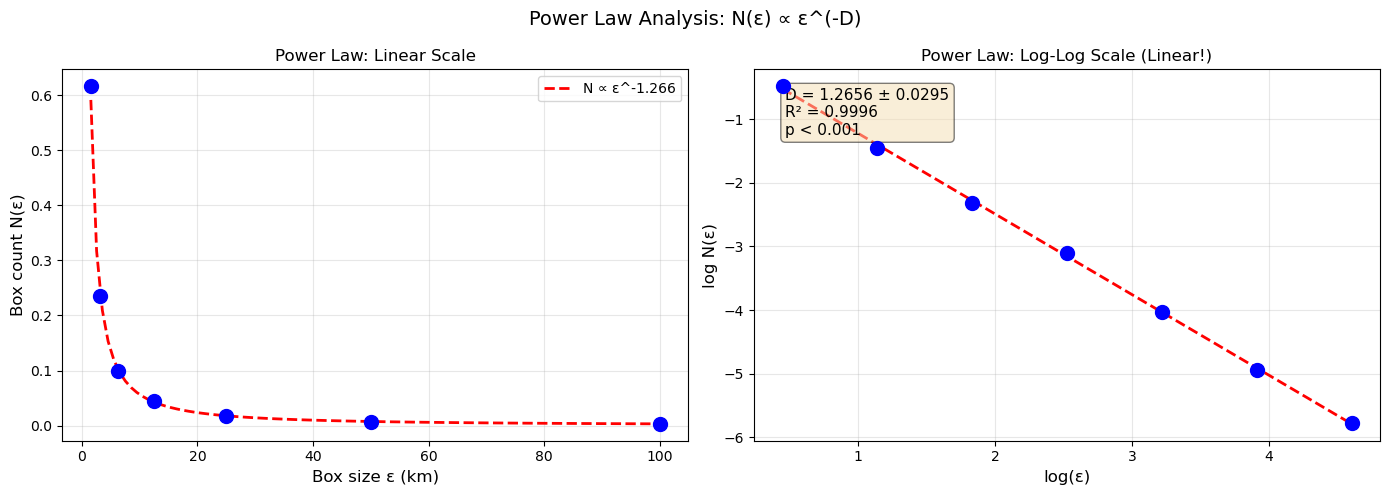


Power Law Analysis Results:
  Exponent (slope) = -1.2656
  Fractal Dimension D = 1.2656
  95% CI: [1.2361, 1.2951]
  R² = 0.9996
  True D = 1.26


In [8]:
# Demonstrate power law fitting with confidence intervals
def power_law_analysis(x, y, name=""):
    """Analyze power law relationship with statistics."""
    log_x = np.log(x)
    log_y = np.log(y)
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x, log_y)
    
    # Confidence intervals (95%)
    n = len(x)
    t_val = stats.t.ppf(0.975, n - 2)
    slope_ci = t_val * std_err
    
    return {
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2,
        'p_value': p_value,
        'std_err': std_err,
        'ci_95': slope_ci,
        'name': name
    }

# Generate example: coastline-like data
np.random.seed(42)
epsilon = np.array([100, 50, 25, 12.5, 6.25, 3.125, 1.5625])  # km
D_true = 1.26  # True dimension
C = 1.0
# Add some noise
N = C * epsilon ** (-D_true) * np.exp(np.random.normal(0, 0.05, len(epsilon)))

result = power_law_analysis(epsilon, N, "Coastline")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].scatter(epsilon, N, s=100, c='blue', zorder=5)
eps_fit = np.linspace(epsilon.min(), epsilon.max(), 100)
N_fit = np.exp(result['intercept']) * eps_fit ** result['slope']
axes[0].plot(eps_fit, N_fit, 'r--', lw=2, label=f'N ∝ ε^{result["slope"]:.3f}')
axes[0].set_xlabel('Box size ε (km)', fontsize=12)
axes[0].set_ylabel('Box count N(ε)', fontsize=12)
axes[0].set_title('Power Law: Linear Scale', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log-log scale
axes[1].scatter(np.log(epsilon), np.log(N), s=100, c='blue', zorder=5)
log_eps = np.log(eps_fit)
axes[1].plot(log_eps, result['slope'] * log_eps + result['intercept'], 'r--', lw=2)
axes[1].set_xlabel('log(ε)', fontsize=12)
axes[1].set_ylabel('log N(ε)', fontsize=12)
axes[1].set_title('Power Law: Log-Log Scale (Linear!)', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Annotate with statistics
stats_text = f"D = {-result['slope']:.4f} ± {result['ci_95']:.4f}\nR² = {result['r_squared']:.4f}\np < 0.001"
axes[1].annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction', 
                 fontsize=11, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

fig.suptitle('Power Law Analysis: N(ε) ∝ ε^(-D)', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nPower Law Analysis Results:")
print(f"  Exponent (slope) = {result['slope']:.4f}")
print(f"  Fractal Dimension D = {-result['slope']:.4f}")
print(f"  95% CI: [{-result['slope'] - result['ci_95']:.4f}, {-result['slope'] + result['ci_95']:.4f}]")
print(f"  R² = {result['r_squared']:.4f}")
print(f"  True D = {D_true}")

## 2.5 The Hurst Exponent and Fractional Brownian Motion

The **Hurst exponent** $H$ characterizes long-range dependence in time series.

### Fractional Brownian Motion (fBm)

- $H = 0.5$: Standard Brownian motion (random walk), uncorrelated increments
- $H > 0.5$: **Persistent** (trending) behavior - trends continue
- $H < 0.5$: **Anti-persistent** (mean-reverting) behavior - trends reverse

### Relationship to Fractal Dimension

For a 1D fBm trace: $D = 2 - H$

For a 2D fBm surface: $D = 3 - H$

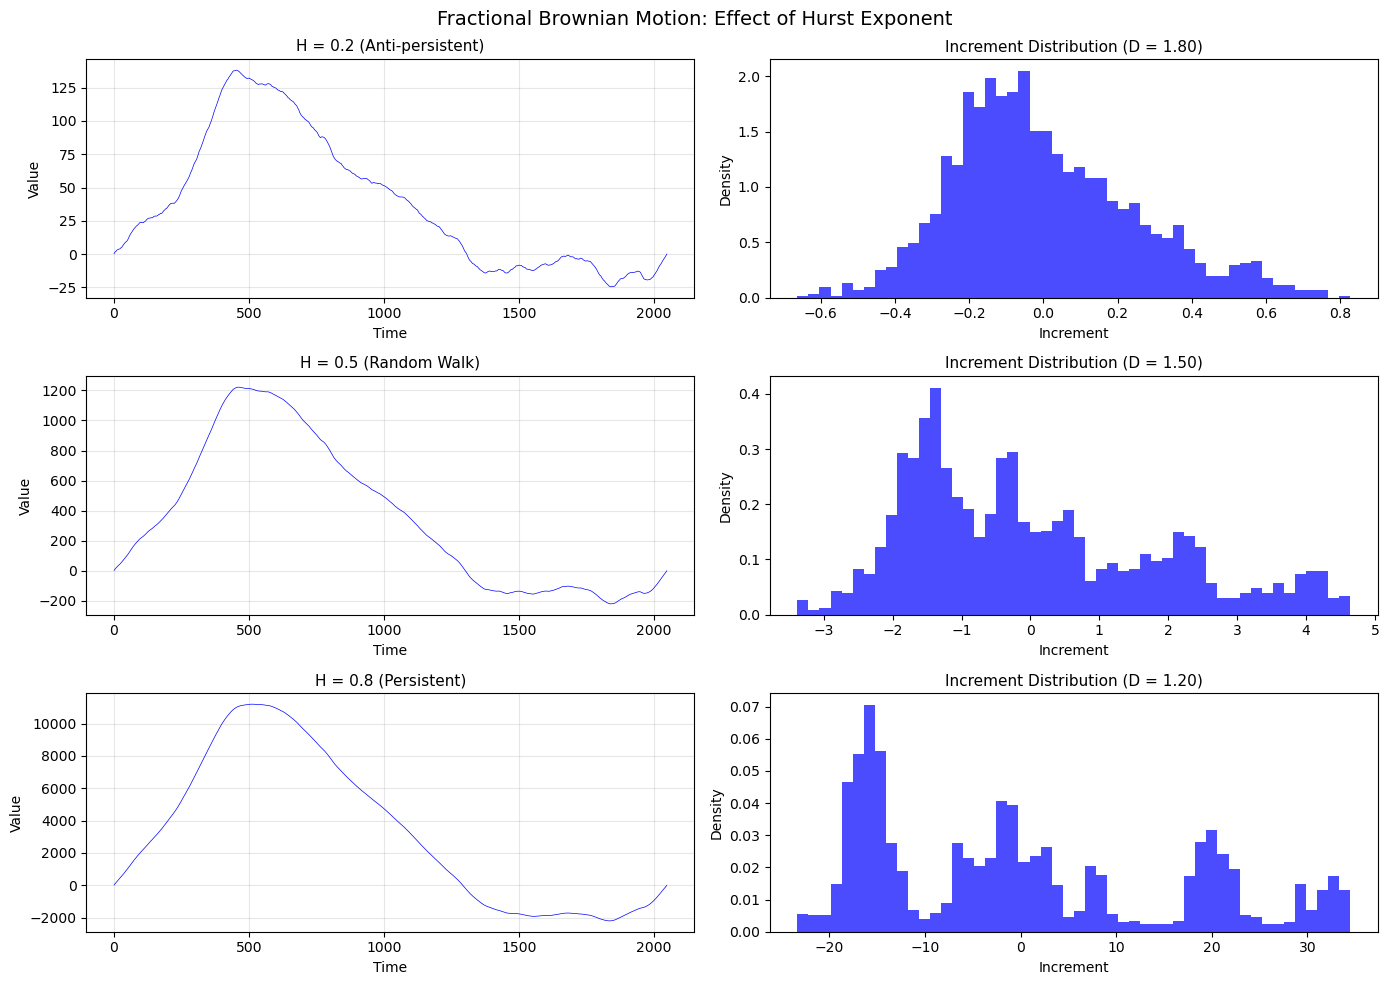

Hurst Exponent Interpretation:
  H < 0.5: Anti-persistent (mean-reverting), rougher trace, D > 1.5
  H = 0.5: Random walk (Brownian motion), D = 1.5
  H > 0.5: Persistent (trending), smoother trace, D < 1.5


In [9]:
def generate_fbm_1d(n, H, seed=None):
    """
    Generate 1D fractional Brownian motion using spectral synthesis.
    
    Parameters:
    - n: number of points
    - H: Hurst exponent (0 < H < 1)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Frequency
    freq = np.fft.fftfreq(n)
    freq[0] = 1e-10  # Avoid division by zero
    
    # Power spectrum: S(f) ~ 1/f^(2H+1)
    beta = 2 * H + 1
    spectrum = 1.0 / np.abs(freq) ** (beta / 2)
    spectrum[0] = 0
    
    # Random phases (ensure conjugate symmetry for real output)
    phases = np.exp(2j * np.pi * np.random.rand(n))
    phases[n//2+1:] = np.conj(phases[1:n//2][::-1])
    phases[0] = 1
    if n % 2 == 0:
        phases[n//2] = 1
    
    # Generate
    fft_signal = spectrum * phases
    signal = np.real(np.fft.ifft(fft_signal))
    
    # Cumulative sum to get fBm from fGn
    fbm = np.cumsum(signal)
    
    return fbm

# Visualize fBm with different H values
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

H_values = [0.2, 0.5, 0.8]
n = 2048

for i, H in enumerate(H_values):
    fbm = generate_fbm_1d(n, H, seed=42)
    
    # Time series
    axes[i, 0].plot(fbm, 'b-', lw=0.5)
    axes[i, 0].set_title(f'H = {H} ({"Anti-persistent" if H < 0.5 else "Persistent" if H > 0.5 else "Random Walk"})', fontsize=11)
    axes[i, 0].set_xlabel('Time')
    axes[i, 0].set_ylabel('Value')
    axes[i, 0].grid(True, alpha=0.3)
    
    # Increments histogram
    increments = np.diff(fbm)
    axes[i, 1].hist(increments, bins=50, density=True, alpha=0.7, color='blue')
    axes[i, 1].set_title(f'Increment Distribution (D = {2-H:.2f})', fontsize=11)
    axes[i, 1].set_xlabel('Increment')
    axes[i, 1].set_ylabel('Density')

fig.suptitle('Fractional Brownian Motion: Effect of Hurst Exponent', fontsize=14)
plt.tight_layout()
plt.show()

print("Hurst Exponent Interpretation:")
print("  H < 0.5: Anti-persistent (mean-reverting), rougher trace, D > 1.5")
print("  H = 0.5: Random walk (Brownian motion), D = 1.5")
print("  H > 0.5: Persistent (trending), smoother trace, D < 1.5")

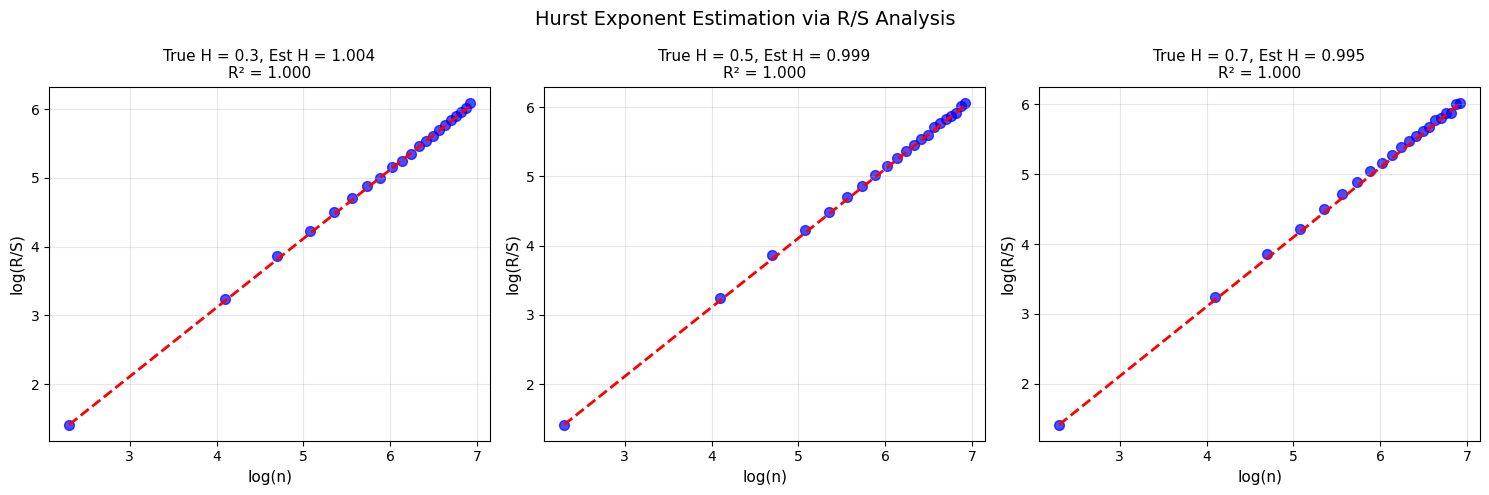

In [10]:
def estimate_hurst_rs(signal):
    """
    Estimate Hurst exponent using Rescaled Range (R/S) analysis.
    
    R/S ~ n^H where n is the window size.
    """
    n = len(signal)
    
    # Range of window sizes
    min_window = 10
    max_window = n // 4
    
    window_sizes = []
    rs_values = []
    
    for window in range(min_window, max_window, max(1, (max_window - min_window) // 20)):
        rs_list = []
        
        for start in range(0, n - window, window):
            segment = signal[start:start + window]
            mean = np.mean(segment)
            
            # Cumulative deviation from mean
            cumdev = np.cumsum(segment - mean)
            
            # Range
            R = np.max(cumdev) - np.min(cumdev)
            
            # Standard deviation
            S = np.std(segment, ddof=1)
            
            if S > 0:
                rs_list.append(R / S)
        
        if rs_list:
            window_sizes.append(window)
            rs_values.append(np.mean(rs_list))
    
    # Linear regression on log-log scale
    log_n = np.log(window_sizes)
    log_rs = np.log(rs_values)
    
    slope, intercept, r_value, _, _ = stats.linregress(log_n, log_rs)
    
    return slope, r_value**2, np.array(window_sizes), np.array(rs_values)

# Test Hurst estimation on fBm with known H
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

H_values = [0.3, 0.5, 0.7]

for i, H_true in enumerate(H_values):
    fbm = generate_fbm_1d(4096, H_true, seed=42)
    H_est, r2, windows, rs = estimate_hurst_rs(fbm)
    
    log_n = np.log(windows)
    log_rs = np.log(rs)
    
    axes[i].scatter(log_n, log_rs, s=50, c='blue', alpha=0.7)
    axes[i].plot(log_n, H_est * log_n + (log_rs[0] - H_est * log_n[0]), 'r--', lw=2)
    axes[i].set_xlabel('log(n)', fontsize=11)
    axes[i].set_ylabel('log(R/S)', fontsize=11)
    axes[i].set_title(f'True H = {H_true}, Est H = {H_est:.3f}\nR² = {r2:.3f}', fontsize=11)
    axes[i].grid(True, alpha=0.3)

fig.suptitle('Hurst Exponent Estimation via R/S Analysis', fontsize=14)
plt.tight_layout()
plt.show()

## 2.6 Lacunarity: Measuring Texture and Gaps

Fractal dimension alone doesn't fully characterize a fractal's appearance. **Lacunarity** quantifies the "gappiness" or texture.

### Definition

$$\Lambda(r) = \frac{\mathbb{E}[M(r)^2]}{(\mathbb{E}[M(r)])^2}$$

where $M(r)$ is the mass (count) in a box of size $r$.

### Interpretation

- **High lacunarity**: Large, heterogeneous gaps; clumped patterns
- **Low lacunarity**: Small, uniform gaps; homogeneous patterns

Two fractals can have identical dimension but different lacunarity!

In [11]:
def gliding_box_lacunarity(image, box_sizes=None):
    """
    Compute lacunarity using the gliding box algorithm.
    
    Parameters:
    - image: 2D binary numpy array
    - box_sizes: list of box sizes
    
    Returns:
    - sizes: array of box sizes
    - lacunarities: array of lacunarity values
    """
    Z = (image > 0).astype(float)
    h, w = Z.shape
    
    if box_sizes is None:
        max_size = min(h, w) // 4
        box_sizes = list(range(2, max_size, max(1, max_size // 20)))
    
    lacunarities = []
    sizes = []
    
    for r in box_sizes:
        if r >= min(h, w):
            continue
            
        # Compute box masses using uniform filter (efficient gliding box)
        from scipy.ndimage import uniform_filter
        
        # Sum in each box
        box_sums = uniform_filter(Z, size=r, mode='constant', cval=0)
        
        # Only consider valid positions (full boxes)
        valid = box_sums[r//2:h-r//2, r//2:w-r//2] * (r * r)
        
        if valid.size == 0:
            continue
        
        # Compute lacunarity
        mean_mass = np.mean(valid)
        mean_sq_mass = np.mean(valid ** 2)
        
        if mean_mass > 0:
            Lambda = mean_sq_mass / (mean_mass ** 2)
            lacunarities.append(Lambda)
            sizes.append(r)
    
    return np.array(sizes), np.array(lacunarities)

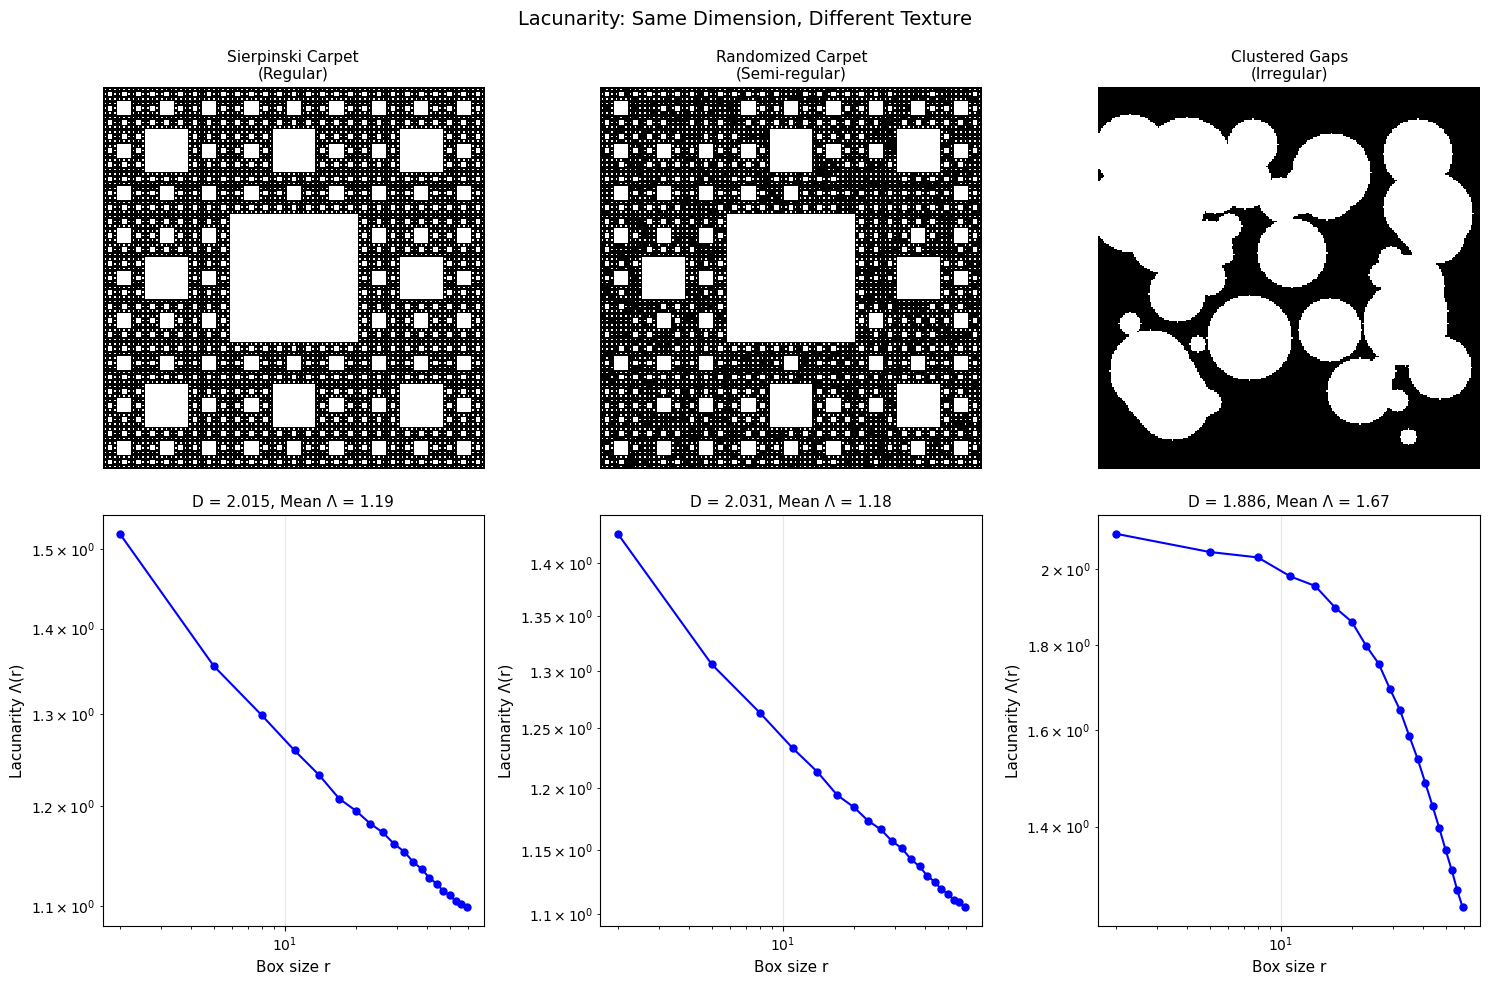

Key Insight: Fractal dimension and lacunarity are complementary measures.
- Dimension quantifies complexity/space-filling
- Lacunarity quantifies texture/gappiness


In [12]:
def generate_random_cantor(size, p=0.5, depth=6):
    """Generate randomized Cantor-like pattern."""
    pattern = np.ones((size, size), dtype=bool)
    
    for d in range(depth):
        step = size // (3 ** (d + 1))
        if step < 1:
            break
        for y in range(0, size, step * 3):
            for x in range(0, size, step * 3):
                if np.random.rand() < p:
                    pattern[y + step:y + 2*step, x + step:x + 2*step] = False
    
    return pattern

# Generate patterns with same dimension but different lacunarity
np.random.seed(42)

# Regular Sierpinski carpet (low lacunarity - uniform gaps)
carpet_regular = generate_sierpinski(243, 5)

# Random pattern (higher lacunarity - clustered gaps)
carpet_random = generate_random_cantor(243, p=0.8, depth=5)

# Highly clustered pattern
carpet_clustered = np.ones((243, 243), dtype=bool)
# Add large random clusters
for _ in range(50):
    cx, cy = np.random.randint(20, 223, 2)
    r = np.random.randint(5, 30)
    y, x = np.ogrid[:243, :243]
    mask = (x - cx)**2 + (y - cy)**2 <= r**2
    carpet_clustered[mask] = False

patterns = [
    (carpet_regular, "Sierpinski Carpet\n(Regular)"),
    (carpet_random, "Randomized Carpet\n(Semi-regular)"),
    (carpet_clustered, "Clustered Gaps\n(Irregular)")
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (pattern, title) in enumerate(patterns):
    # Show pattern
    axes[0, i].imshow(pattern, cmap='binary', interpolation='nearest')
    axes[0, i].set_title(title, fontsize=11)
    axes[0, i].axis('off')
    
    # Box counting for dimension
    sizes_bc, counts_bc, dim, r2 = box_count(pattern)
    
    # Lacunarity
    sizes_lac, lac = gliding_box_lacunarity(pattern)
    
    # Plot lacunarity
    axes[1, i].loglog(sizes_lac, lac, 'b-o', markersize=5)
    axes[1, i].set_xlabel('Box size r', fontsize=11)
    axes[1, i].set_ylabel('Lacunarity Λ(r)', fontsize=11)
    axes[1, i].set_title(f'D = {dim:.3f}, Mean Λ = {np.mean(lac):.2f}', fontsize=11)
    axes[1, i].grid(True, alpha=0.3)

fig.suptitle('Lacunarity: Same Dimension, Different Texture', fontsize=14)
plt.tight_layout()
plt.show()

print("Key Insight: Fractal dimension and lacunarity are complementary measures.")
print("- Dimension quantifies complexity/space-filling")
print("- Lacunarity quantifies texture/gappiness")

## Summary: Mathematical Toolkit

| Concept | Symbol | Key Formula | Application |
|---------|--------|-------------|-------------|
| Box-counting dimension | $D_B$ | $\lim \frac{\log N(\varepsilon)}{\log(1/\varepsilon)}$ | Practical measurement |
| Power law scaling | - | $N \propto \varepsilon^{-D}$ | Fundamental relationship |
| Hurst exponent | $H$ | $D = 2 - H$ (1D) | Time series, roughness |
| Lacunarity | $\Lambda$ | $\frac{\mathbb{E}[M^2]}{(\mathbb{E}[M])^2}$ | Texture, gaps |

**Next:** See `3_dimensionality.ipynb` for fractal examples across 1D, 2D, 3D, and 4D.

In [13]:
# Summary comparison table
print("Summary of Fractal Measurement Methods")
print("=" * 70)
print(f"{'Method':<25} {'Input':<20} {'Output':<25}")
print("-" * 70)
print(f"{'Box-Counting':<25} {'Binary image/set':<20} {'Fractal dimension D':<25}")
print(f"{'Differential BC':<25} {'Grayscale image':<20} {'Surface dimension D':<25}")
print(f"{'R/S Analysis':<25} {'Time series':<20} {'Hurst exponent H':<25}")
print(f"{'Gliding Box':<25} {'Binary image':<20} {'Lacunarity Λ(r)':<25}")
print("=" * 70)

Summary of Fractal Measurement Methods
Method                    Input                Output                   
----------------------------------------------------------------------
Box-Counting              Binary image/set     Fractal dimension D      
Differential BC           Grayscale image      Surface dimension D      
R/S Analysis              Time series          Hurst exponent H         
Gliding Box               Binary image         Lacunarity Λ(r)          
